Class Distribution:
label
Web           30000
Recon         30000
Mirai         30000
BruteForce    30000
Spoofing      30000
DoS           30000
Benign        30000
DDoS          30000
Name: count, dtype: int64


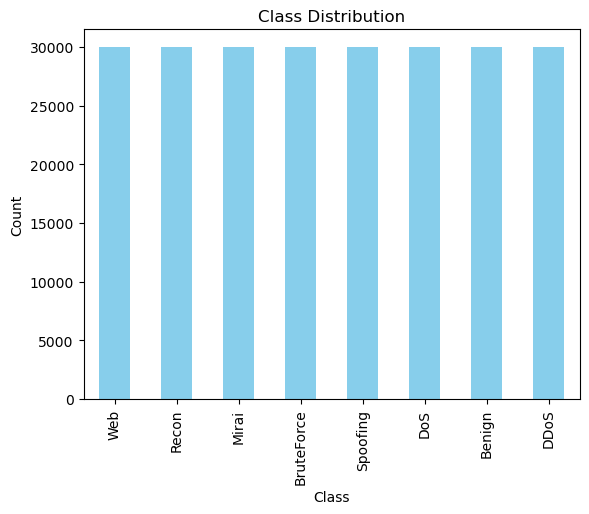

Train Shape: (192000, 46), Test Shape: (48000, 46)
Test Accuracy: 0.8539
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.83      0.79      6000
           1       0.79      0.78      0.78      6000
           2       1.00      1.00      1.00      6000
           3       1.00      1.00      1.00      6000
           4       1.00      1.00      1.00      6000
           5       0.77      0.70      0.74      6000
           6       0.80      0.79      0.79      6000
           7       0.73      0.73      0.73      6000

    accuracy                           0.85     48000
   macro avg       0.85      0.85      0.85     48000
weighted avg       0.85      0.85      0.85     48000



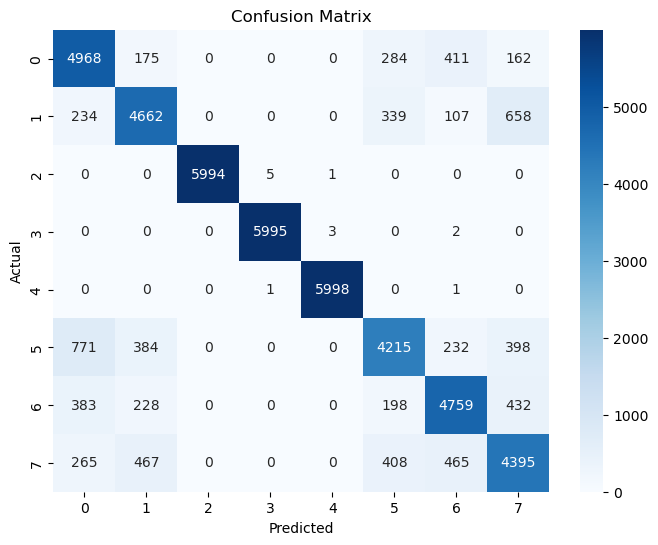

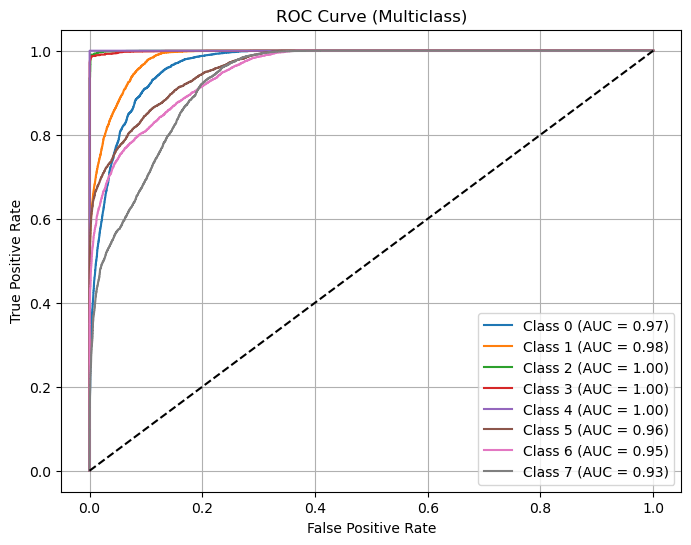

In [1]:
# ==============================
# 1. Import Libraries
# ==============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc

# ==============================
# 2. Load Dataset
# ==============================
df = pd.read_csv("/Users/bodapati/Downloads/balanced_dataset3.csv")

# ==============================
# 3. Show Class Distribution
# ==============================
print("Class Distribution:")
print(df['label'].value_counts())
df['label'].value_counts().plot(kind='bar', color='skyblue')
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

# ==============================
# 4. Define Features and Target
# ==============================
features = ['flow_duration', 'Header_Length', 'Protocol Type', 'Duration', 'Rate', 'Srate', 'Drate',
            'fin_flag_number', 'syn_flag_number', 'rst_flag_number', 'psh_flag_number', 'ack_flag_number',
            'ece_flag_number', 'cwr_flag_number', 'ack_count', 'syn_count', 'fin_count', 'urg_count',
            'rst_count', 'HTTP', 'HTTPS', 'DNS', 'Telnet', 'SMTP', 'SSH', 'IRC', 'TCP', 'UDP', 'DHCP',
            'ARP', 'ICMP', 'IPv', 'LLC', 'Tot sum', 'Min', 'Max', 'AVG', 'Std', 'Tot size', 'IAT',
            'Number', 'Magnitue', 'Radius', 'Covariance', 'Variance', 'Weight']
target = 'label'

X = df[features]
y = df[target]

# Encode target if needed
if y.dtype == 'object':
    le = LabelEncoder()
    y = le.fit_transform(y)

# ==============================
# 5. Train/Test Split
# ==============================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train Shape: {X_train.shape}, Test Shape: {X_test.shape}")

# ==============================
# 6. Scale Features
# ==============================
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# ==============================
# 7. Train Optimized AdaBoost
# ==============================
base_estimator = DecisionTreeClassifier(max_depth=3, random_state=42)  # deeper tree
adaboost = AdaBoostClassifier(
    estimator=base_estimator,
    n_estimators=400,       # more estimators
    learning_rate=0.7,      # higher learning rate
    random_state=42
)
adaboost.fit(X_train, y_train)

# ==============================
# 8. Predictions
# ==============================
y_pred = adaboost.predict(X_test)
y_prob = adaboost.predict_proba(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

# ==============================
# 9. Confusion Matrix
# ==============================
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ==============================
# 10. ROC Curve
# ==============================
if len(np.unique(y)) > 2:
    y_test_bin = label_binarize(y_test, classes=np.unique(y))
    plt.figure(figsize=(8,6))
    for i in range(y_test_bin.shape[1]):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')
    plt.plot([0,1],[0,1],'k--')
    plt.title("ROC Curve (Multiclass)")
else:
    fpr, tpr, _ = roc_curve(y_test, y_prob[:,1])
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, color='blue', label=f'AUC = {roc_auc:.2f}')
    plt.plot([0,1],[0,1],'k--')
    plt.title("ROC Curve")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()